In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from graspy.embed import AdjacencySpectralEmbed
from graspy.plot import pairplot
from graspy.embed import OutOfSampleAdjacencySpectralEmbed as OOSASE
import graspy

import networkx as nx

import _pickle as pkl
# Need OOS

In [2]:
np.random.seed(1)
reload_data = False

if reload_data:
    nodes = pd.read_csv('nodes', delimiter='\t')
    print(nodes.head())

    edges = pd.read_csv('edges', delimiter='\t',header=None)
    print(edges.head())

    G = nx.from_pandas_edgelist(edges, source=0, target=1)
    lcc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(lcc).copy()
    pkl.dump(G_lcc, open('nas_graph.pkl', 'wb'))
    
    N = len(G_lcc)
    in_sample_prop = 0.2

    nodes = pd.read_csv('nodes', delimiter='\t')['hash']

    in_sample_id = np.random.choice(nodes, int(N*0.2))

    temp_G = G_lcc.subgraph(in_sample_id).copy()
    lcc = max(nx.connected_components(temp_G))

    in_sample_G = temp_G.subgraph(lcc).copy()

    pkl.dump(in_sample_G, open('in_sample_G.pkl', 'wb'))
else:
#     G_lcc = pkl.load(open('nas_graph.pkl', 'rb'))
    in_sample_G = pkl.load(open('in_sample_G.pkl', 'rb'))
    
# print('largest connected component:' + str(len(G_lcc)))
print('in sample size:' + str(len(in_sample_G)))

in sample size:46398


In [12]:
oos_ase = OOSASE(n_components=100,in_sample_proportion=1, connected_attempts=100, check_lcc=False)
oos_ase.fit(in_sample_G)

in_sample_ids = oos_ase.in_sample_ids

X_hat = oos_ase.latent_left_
sing_vals = oos_ase.singular_values_

begin svd


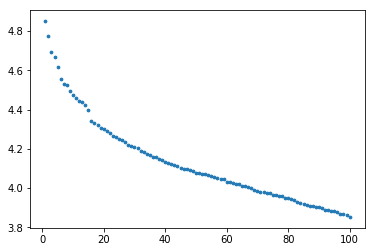

In [35]:
fig, ax = plt.subplots(1,1)
ax.scatter(range(1, len(sing_vals)+1), sing_vals, s=7.5)

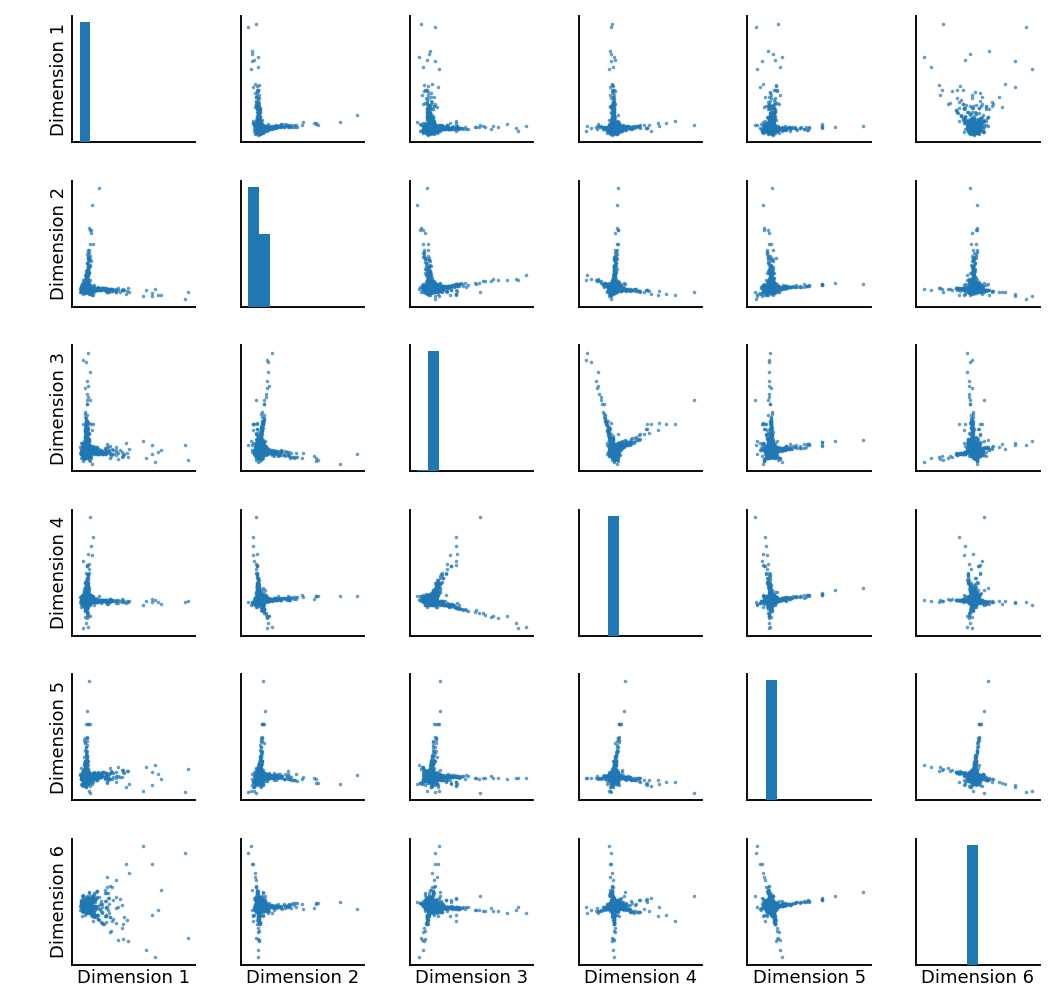

In [16]:
pairplot(X_hat[:, :6])

In [19]:
nodes = pd.read_csv('nodes', delimiter='\t')
node_ids = nodes['hash']
nodes.head()

,hash,mean_final_validation_accuracy,mean_final_training_time
0,00005c142e6f48ac74fdcf73e3439874,0.926416,1768.784953
1,0000718c96730a92ea6d5242f8ce77e2,0.894631,1206.150024
2,0000cb5372fad9d62c470df699ac6d52,0.927350,1343.049967
3,0000fa05697179112aaf69c2f0a51a0f,0.909756,1302.710978
4,00010e19334eb9dcbe1fe61a98d524c2,0.897169,1251.861003


In [37]:
in_sample_nodes = nodes[nodes.hash.isin(oos_ase.in_sample_id)].copy()

from tqdm import tqdm
rearranged_scores = np.zeros(len(in_sample_ids))

for i, id_ in enumerate(tqdm(in_sample_ids)):
    rearranged_scores[i] = in_sample_nodes[in_sample_nodes.hash == id_]['mean_final_validation_accuracy']

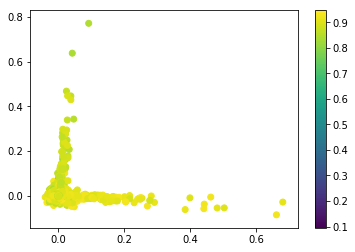

In [60]:
zero_to_one = (rearranged_scores - min(rearranged_scores)) / (max(rearranged_scores) - min(rearranged_scores))

fig, ax = plt.subplots(1,1)
im = ax.scatter(X_hat[:, 0], X_hat[:, 1], c = rearranged_scores)
fig.colorbar(im, ax=ax)